In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
import pandas as pd

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [3]:
#fname,fnamey="x_def_3d.dat","y_def_3d.dat"
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 1000   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [4]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

1552.6302096770091
mean minimum distance between points:  18.557579101240194


In [88]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=6) #data is 3 dimentional, 
neighbors_fit = neighbors.fit(x)
distances, indices = neighbors_fit.kneighbors(x)
distances = np.sort(distances, axis=0)
print(np.shape(dists))
print(np.shape(distances[:,2]))
print(np.shape(dists[1]))
dists = np.zeros((6,1000))
#up to the 6th neigbor
for i in range(2,6): #from 2nd to 20th(minSamples_max) sample nearest neibour 
    dists[i-2] = distances[:,i] 
   


(6, 1000)
(1000,)
(1000,)


In [91]:
mean_dist_all = dists.mean()
print(mean_dist_all) #mean minimum distance from all the elements

25.044391470367128


## t-SNE visualization, for true labels

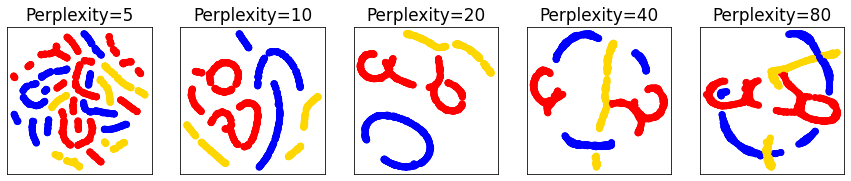

In [5]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

In [6]:
NMIs = []
df = pd.DataFrame(columns = ['eps','minPts','NMIs'])
for i in range(20):
    if (i%4 ==0):
        df.at[i,"minPts"]=3
    if (i%4 ==1 or i==1):
        df.at[i,"minPts"]=5
    if (i%4 ==2 or i==2):
        df.at[i,"minPts"] = 10
    if (i%4 == 3 or i ==3):
        df.at[i,"minPts"]=20
    if (i<4):
        df.at[i,"eps"] = 18.0
    elif (i<8):
        df.at[i,"eps"] = 54.0
    elif (i<12):
        df.at[i,"eps"] = 108.0
    elif (i <16):
        df.at[i,"eps"] = 162.0
    else:
        df.at[i,"eps"] = 216.0
        

## DBSCAN: find labels by applying clustering

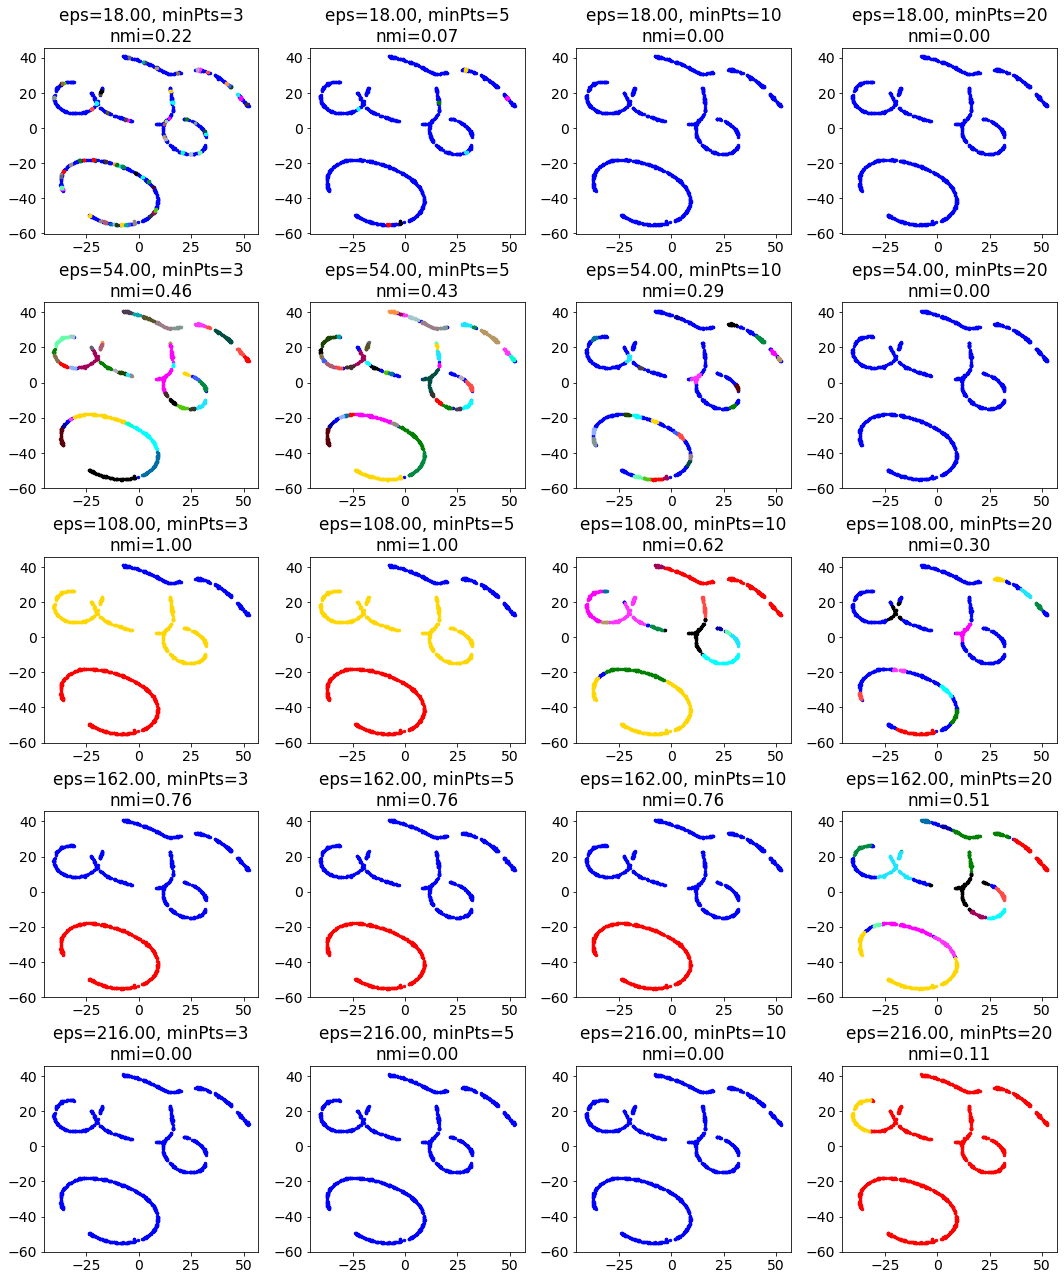

In [7]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[3] # best visualization above
X = data
y_true = y                        ###### was y_true = y originally 

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r,3*r,6*r,9*r,12*r]
min_sample_range = [3,5,10,20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i,j])
        nmi=NMI(y_hat, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
        NMIs = np.append(NMIs, nmi)
        
plt.tight_layout(h_pad=0.5)
plt.show()


In [10]:
for i in range (19):
    df.at[i,"NMIs"] = NMIs[i] #why does it return NaN for the last NMI? 
df.at[19,"NMIs"]= NMIs[19] #fixed it manually 
print(len(NMIs))  
df
    

20


,eps,minPts,NMIs
0,18.0,3,0.222287
1,18.0,5,0.066108
2,18.0,10,0.0
3,18.0,20,0.0
4,54.0,3,0.458153
5,54.0,5,0.427656
6,54.0,10,0.288544
7,54.0,20,0.0
8,108.0,3,1.0
9,108.0,5,1.0


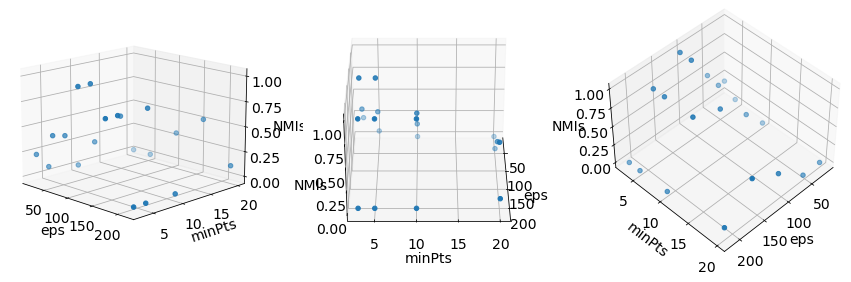

In [11]:
fig = plt.figure(figsize=(15, 15))
xs = df['eps']
ys = df['minPts']
zs = df['NMIs']

for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(xs, ys, zs)
    ax.view_init(15+15*i, 45*(i-1))
    ax.set_xlabel('eps')
    ax.set_ylabel('minPts')
    ax.set_zlabel('NMIs')


plt.show()


As can be seen from the scatter plot above, there is no clear correlation between the number of eps and minPts to the NMI values. The best way to get the highest NMI is probably by doing a gridsearch on the data and trying different eps and minPTS

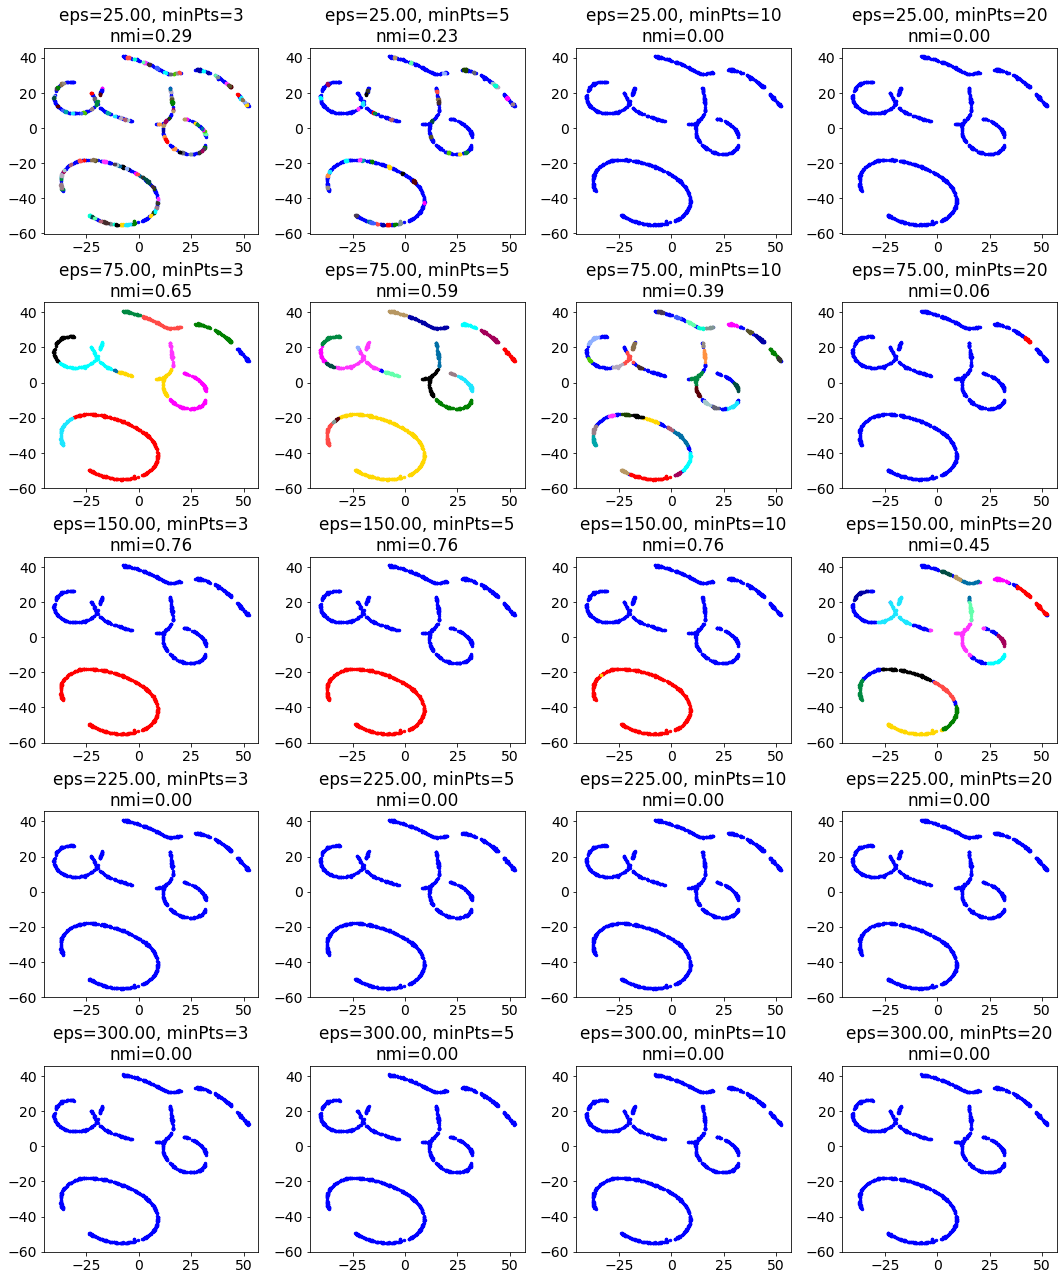

In [95]:
#eps_range = [0.01,0.1,0.5,1.0,10.]  #trying the same with all the min distances mean
if mean_dist_all<10:  
    r=mean_dist_all
else:
    r = int(mean_dist_all)
eps_range = [r,3*r,6*r,9*r,12*r]
min_sample_range = [3,5,10,20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i,j])
        nmi=NMI(y_hat, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
        NMIs = np.append(NMIs, nmi)
        
plt.tight_layout(h_pad=0.5)
plt.show()


We counted the mean minimum distance from all the from all the points and implemented the algorithm again with using that mean. However, as we can see from above, the NMI did not impove, but it got worse. The most we got is 2 clusters and maximum NMI = 0.76, while we used to have NMI=1 and 3 clusters before. 